A notebook for trying to reproduce some of the results of Yin et al 2020 "Response of Storm-Related Extreme Sea Level along the U.S. Atlantic Coast to Combined Weather and Climate Forcing"
Contents:
* Introduction
* Timeseries
* Seasonal cycle
* Histograms
* Extremes
* Robustness of extremes

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import genpareto

In [3]:
# Load bathymetry data
bath_data = xr.open_dataset('~/Research/data/bathymetry.nc')
xt_coastal = np.load('/Users/andrewbrettin/Research/data/xt_coastal.npy')
yt_coastal = np.load('/Users/andrewbrettin/Research/data/yt_coastal.npy')

In [4]:
# Load sea level data
flattened_sla = xr.open_dataarray('~/Research/data/coastal_masked_sla.nc') # Time-mean removed, not actually anomalies
flattened_sl = xr.open_dataarray('~/Research/data/coastal_masked_sl.nc')
num_coastal_coords = len(flattened_sla.data[0, :])
flattened_sla

<xarray.DataArray 'sea_level' (time: 5844, z: 202576)>
array([[      nan,  0.012406,  0.007953, ...,  0.115722,  0.110658,       nan],
       [      nan,  0.018421,  0.014125, ...,  0.109191,  0.104669,       nan],
       [      nan,  0.020964,  0.016373, ...,  0.111335,  0.108699,       nan],
       ...,
       [      nan, -0.033831, -0.032682, ...,  0.089783,  0.082973,       nan],
       [      nan, -0.030859, -0.03012 , ...,  0.069628,  0.066091,       nan],
       [      nan, -0.041029, -0.040172, ...,  0.069225,  0.063765,       nan]],
      dtype=float32)
Coordinates:
  * time      (time) object 0185-01-01 12:00:00 ... 0200-12-31 12:00:00
    xt_ocean  (z) float64 ...
    yt_ocean  (z) float64 ...
Dimensions without coordinates: z

Since there are many coordinates in the sea level data which don't actually have any sea level, here we will use a pandas dataframe to extract coordinates only where there is significant sea level data.

In [5]:
# Load sea level statistics
sea_level_stats = xr.open_dataset('~/Research/data/sea_level_statistics.nc')
hist = sea_level_stats.sla_histogram

# Create dataframe of sea level statistics for coastal coordinates
sea_level_statistics = xr.open_dataset('~/Research/data/sea_level_statistics_seasonalremoved.nc')
sea_level_statistics = sea_level_statistics.drop_vars('sla_histogram').drop_dims('bins')
df = sea_level_statistics.to_dataframe()

# Bathymetry
bathymetry = xr.open_dataset('~/Research/data/bathymetry.nc')
shelf_length = bathymetry['shelf_length']
shore_angle = bathymetry['theta']
yt = xr.open_dataset('~/Research/data/coastal_coords.nc')['lat'].data
xt = xr.open_dataset('~/Research/data/coastal_coords.nc')['long'].data
flattened_shelf_lengths = shelf_length.sel(yt_ocean=xr.DataArray(yt, dims='z'), xt_ocean=xr.DataArray(xt, dims='z'))

df['shelf_length'] = flattened_shelf_lengths.data

df = df[df['std'] > 0]
df

,yt_ocean,xt_ocean,std,skew,kurtosis,shelf_length
z,,,,,,
1,-67.972192,-279.95,0.053030,0.157494,3.186391,9396.781165
2,-67.929953,-279.95,0.053540,0.181983,3.102077,4698.563082
3,6.038792,-279.95,0.034749,-0.401816,4.621854,11059.860138
4,6.138228,-279.95,0.035345,-0.398961,4.562818,22117.723402
7,9.900367,-279.95,0.031537,-0.085927,3.987101,142360.564574
...,...,...,...,...,...,...
202570,11.178407,79.95,0.042302,0.272372,4.004626,42927.338598
202571,11.276494,79.95,0.042597,0.297748,4.221291,20999.207570
202572,11.962145,79.95,0.042647,0.283448,4.256202,33150.082268


In [6]:
df.loc[102580]

yt_ocean        39.259491
xt_ocean       -76.450000
std              0.122137
skew             0.119144
kurtosis         5.627589
shelf_length          NaN
Name: 102580, dtype: float64

In [7]:
# Geographical coordinates for East Coast cities (lat, long)
# Determined by google searching coordinates
new_york_geocoords = (40.7128, -74.0060)
miami_geocoords = (25.7617, -80.1918)
new_orleans_geocoords = (29.9511, -90.0715)
halifax_geocoords = (44.6488, -63.5752)
boston_geocoords = (42.3601, -71.0589)
baltimore_geocoords = (39.2904, -76.6122)
charleston_geocoords = (32.7765, -79.9311)
tampa_geocoords = (27.9506, -82.4572)
houston_geocoords = (29.7604, -95.3698)

geocoords = {
    'New York': new_york_geocoords,
    'Miami': miami_geocoords,
    'New Orleans': new_orleans_geocoords,
    'Halifax': halifax_geocoords,
    'Boston': boston_geocoords,
    'Baltimore': baltimore_geocoords,
    'Charleston': charleston_geocoords,
    'Tampa': tampa_geocoords,
    'Houston': houston_geocoords
}

# Sanity check to see if it ok to use model coordinates instead of geocoords:
# Loop through and take difference between geocoords and model coords

# for city in geocoords:
#     geolat = bath_data.geolat_t.sel(yt_ocean=geocoords[city][0],
#                                     xt_ocean=geocoords[city][1], method='nearest').data
#     geolon = bath_data.geolon_t.sel(yt_ocean=geocoords[city][0],
#                                     xt_ocean=geocoords[city][1], method='nearest').data
#     print(city, ':  ', round(geolat - geocoords[city][0], 3), '  ', round(geolon - geocoords[city][1], 3))

We can see the largest coordinate difference, ~0.45 at New York, is small compared to the model resolution so we can use the grid coordinates as geological coordinates.

In [8]:
# Find shore-adjacent sea level points near given coastal cities
# closest_index = {}
# for city in geocoords:
#     d = 1;
#     index = 0
#     for i in range(len(df)):
#         dy = np.abs(df.iloc[i]['yt_ocean'] - geocoords[city][0])
#         dx = np.abs(df.iloc[i]['xt_ocean'] - geocoords[city][1])
#         if dx**2 + dy**2 < d**2:
#             d = np.sqrt(dx**2 + dy**2)
#             index = i;
#     closest_index[city] = index
# closest_index
closest_index = {'New York': 57064,
 'Miami': 51882,
 'New Orleans': 46321,
 'Halifax': 65364,
 'Boston': 59495,
 'Baltimore': 54855,
 'Charleston': 52127,
 'Tampa': 50299,
 'Houston': 44714}

In [9]:
# Attributes for creating bar plots

cities = [city for city in geocoords]
z_vals = [df.iloc[closest_index[city]].name for city in geocoords]
colors = ['b', 'c', 'r', 'c', 'r', 'g', 'y', 'b', 'g']
linestyles = ['-', ':', ':', '-', '-', '-', '-', ':', ':']
markers = ['s', 'o', 'o', 's', 's', 's', 's', 'o', 'o']

z_dict = {city:df.iloc[index].name for (city, index) in closest_index.items()}
c_dict = dict(zip(cities, colors))
ls_dict = dict(zip(cities, linestyles))
marker_dict = dict(zip(cities, markers))

lower_bin = -1.5
upper_bin = 1.5
num_bins = 50

In [10]:
cities = [city for city in geocoords]
z_vals = [df.iloc[closest_index[city]].name for city in geocoords]
colors = ['b', 'c', 'r', 'c', 'r', 'g', 'y', 'b', 'g']
linestyles = ['-', ':', ':', '-', '-', '-', '-', ':', ':']
markers = ['s', 'o', 'o', 's', 's', 's', 's', 'o', 'o']

z_dict = {city:df.iloc[index].name for (city, index) in closest_index.items()}
c_dict = dict(zip(cities, colors))
ls_dict = dict(zip(cities, linestyles))
marker_dict = dict(zip(cities, markers))

lower_bin = -1.5
upper_bin = 1.5
num_bins = 50

z_dict = {'New York': 106681,
 'Miami': 97037,
 'New Orleans': 86347,
 'Halifax': 122609,
 'Boston': 111372,
 'Baltimore': 102580,
 'Charleston': 97488,
 'Tampa': 93959,
 'Houston': 83272}

## Timeseries
Let's make a few plots of sea level just to show sort of what we are dealing with here:

(-0.5, 0.5)

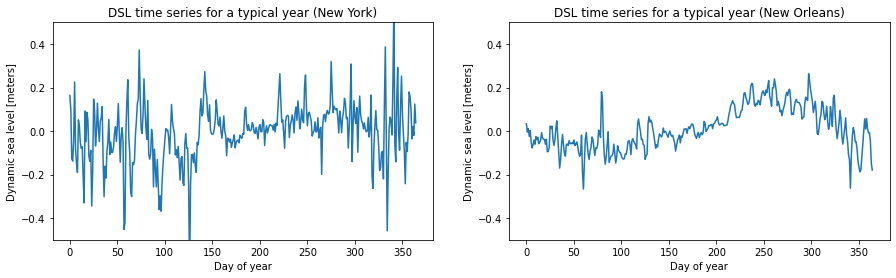

In [11]:
## Plot sea level for New Orleans vs New York in a typical year (Figure 8)
new_york_sl = flattened_sla.isel(z=106681, time=slice(0,365))
new_orleans_sl = flattened_sla.isel(z=86347, time=slice(0,365))
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

ax[0].plot(np.arange(365), new_york_sl.data)
ax[0].set_xlabel('Day of year')
ax[0].set_ylabel('Dynamic sea level [meters]')
ax[0].set_title('DSL time series for a typical year (New York)')
ax[0].set_ylim(-.5, .5)

ax[1].plot(np.arange(365), new_orleans_sl.data)
ax[1].set_xlabel('Day of year')
ax[1].set_ylabel('Dynamic sea level [meters]')
ax[1].set_title('DSL time series for a typical year (New Orleans)')
ax[1].set_ylim(-.5, .5)

## Seasonal cycle
It's clear that there is some variability that is simply due to annual fluctuations. Large deviations due to seasonality don't really represent , so let's subtract this out

In [12]:
## Simulating seasonal cycle 
flattened_sla = xr.open_dataarray('~/Research/data/coastal_masked_sla.nc')
seasonality = flattened_sla.groupby("time.dayofyear").mean("time")
seasonality = seasonality.rolling(dayofyear=10, center=True, min_periods=1).mean()
seasonal_anomaly = flattened_sla.groupby("time.dayofyear") - seasonality

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


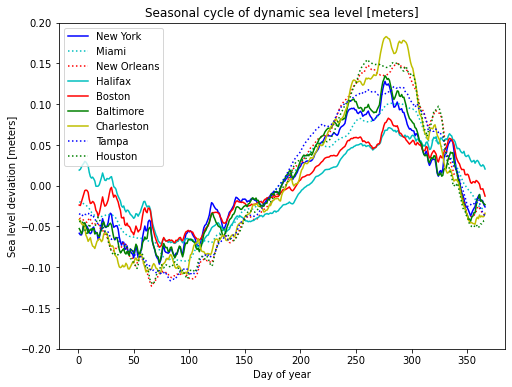

In [10]:
# Plotting seasonal cycle (Fig. 3a)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(len(z_vals)):
    seasonality.isel(z=z_vals[i]).plot(ax=ax, c=colors[i], ls=linestyles[i], label=cities[i])
    ax.set_title('Seasonal cycle of dynamic sea level [meters]')
    ax.set_xlabel('Day of year')
    ax.set_ylabel('Sea level deviation [meters]')
    ax.set_ylim(-0.2, 0.2)
    ax.legend()

(-0.5, 0.5)

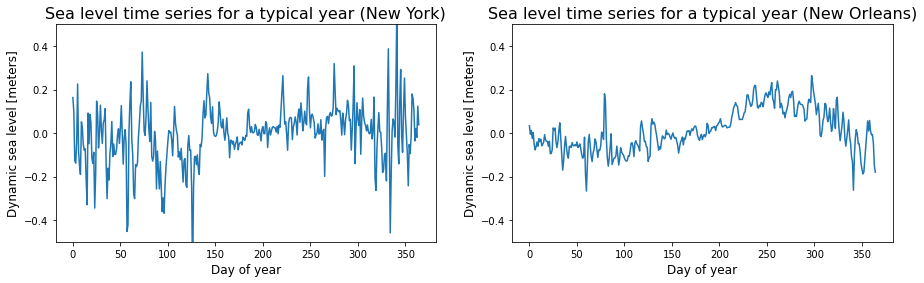

In [174]:
## Plot seasonal anomaly for New Orleans vs New York in a typical year (Figure 8)
# new_york_anom = seasonal_anomaly.isel(z=106681, time=slice(0,365))
# new_orleans_anom = seasonal_anomaly.isel(z=86347, time=slice(0,365))
# fig, ax = plt.subplots(ncols=2, figsize=(15,4))

# ax[0].plot(np.arange(365), new_york_anom.data)
# ax[0].set_xlabel('Day of year', fontsize=12)
# ax[0].set_ylabel('Dynamic SLA [meters]', fontsize=12)
# ax[0].set_title('SLA time series for a typical year (New York)', fontsize=16)
# ax[0].set_ylim(-.5, .5)

# ax[1].plot(np.arange(365), new_orleans_anom.data)
# ax[1].set_xlabel('Day of year', fontsize=12)
# ax[1].set_ylabel('Dynamic SLA [meters]', fontsize=12)
# ax[1].set_title('SLA time series for a typical year (New Orleans)', fontsize=16)
# ax[1].set_ylim(-.5, .5)

new_york_anom = flattened_sla.isel(z=106681, time=slice(0,365))
new_orleans_anom = flattened_sla.isel(z=86347, time=slice(0,365))
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

ax[0].plot(np.arange(365), new_york_anom.data)
ax[0].set_xlabel('Day of year', fontsize=12)
ax[0].set_ylabel('Dynamic sea level [meters]', fontsize=12)
ax[0].set_title('Sea level time series for a typical year (New York)', fontsize=16)
ax[0].set_ylim(-.5, .5)

ax[1].plot(np.arange(365), new_orleans_anom.data)
ax[1].set_xlabel('Day of year', fontsize=12)
ax[1].set_ylabel('Dynamic sea level [meters]', fontsize=12)
ax[1].set_title('Sea level time series for a typical year (New Orleans)', fontsize=16)
ax[1].set_ylim(-.5, .5)

## Sea level histograms

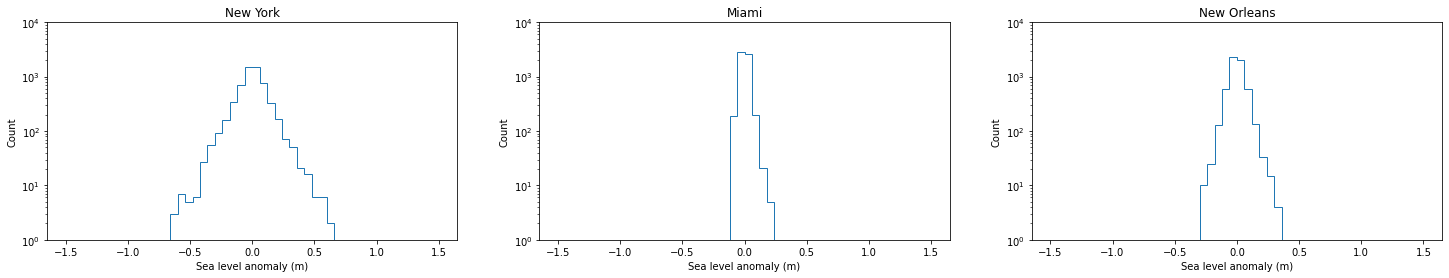

In [138]:
# Plotting histograms
fig = plt.figure(figsize=(25, 4))
axes = [fig.add_subplot(1, 3, k+1) for k in range(3)]
for k in range(3):
    point = seasonal_anomaly.isel(z=z_vals[k])
    n, bins, patches = axes[k].hist(point.data, bins=num_bins, range=(lower_bin, upper_bin),
                                    histtype='step')
    axes[k].set_xlabel('Sea level anomaly (m)')
    axes[k].set_ylabel('Count')
    axes[k].set_yscale('log')
    axes[k].set_title(cities[k])
    axes[k].set_ylim(1, 1e4)

Looks like the right tail of sea level distribution at New Orleans is not represented well in CM2.6 compared to CM4 (Yin et al 2020). CM4 is good at resolving strong cyclones, so the tails from storm surge due to big hurricanes is not shown here.

In [1]:
def plot_histogram(city, pareto_cutoff=None):
    '''Plot histograms of sea level at city'''
    fig, ax = plt.subplots()
    timeseries = seasonal_anomaly.isel(z=z_dict[city]).data
    n, bins, patches = ax.hist(timeseries, bins=num_bins, range=(-.25,.25),
                                    histtype='step')
    ax.set_xlabel('Sea level anomaly (m)')
    ax.set_ylabel('Count')
#     ax.set_yscale('log')
    ax.set_title('Sea level histogram: ' + city)
#     ax.set_ylim(1, 1e4)
    
    if pareto_cutoff:
        cutoff = extreme_values(timeseries, pareto_cutoff)[-1]
        ax.vlines(cutoff, 1, 800, ls=':')
    
    return fig, ax

plot_histogram('Miami')

NameError: name 'plt' is not defined

In [127]:
bool(96)

True

### Sea level extremes

In [27]:
## Calculating return levels using the Peak-over-threshold method
def extreme_values(timeseries, percentile=97):
    # Keep extremes of a timeseries up to a given threshhold (99 in paper, but 95 here)
    sorted_timeseries = sorted(timeseries, reverse=True)
    keep_index = int(np.round(len(timeseries) * (1 - percentile/100)))
    kept_values = sorted_timeseries[0:keep_index]
    
    return kept_values

def return_levels(data, percentile=97, T=365):
    '''Given timeseries data, a threshhold, and return period T, 
    returns the return levels computed from the peak-over-threshhold method'''
    extremes = extreme_values(data, percentile=percentile)
    k, θ, σ = genpareto.fit(extremes)
    
    p = 1/T
    
    if k != 0:
        z_T = θ + σ/k * ((genpareto.sf(θ, k, θ, σ)/p)**k - 1)
    else:
        z_T = θ + σ * np.log(genpareto.sf(θ, k, θ, σ)/p)
    return z_T

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


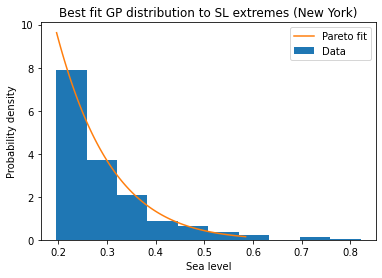

In [28]:
new_york_detrended_timeseries = seasonal_anomaly.isel(z=106681).data
extremes = extreme_values(new_york_detrended_timeseries, percentile=95)

k, θ, σ = genpareto.fit(extremes)
x = np.linspace(genpareto.ppf(0.01, k, θ, σ), genpareto.ppf(0.99, k, θ, σ), 100)

fig, ax = plt.subplots()
ax.hist(extremes, density=True, label='Data')
ax.plot(x, genpareto.pdf(x, k, θ, σ), label='Pareto fit')
ax.legend()
ax.set_xlabel('Sea level')
ax.set_ylabel('Probability density')
ax.set_title('Best fit GP distribution to SL extremes (New York)');

In [29]:
## Computing the 1-year and 10-year return levels
new_york_detrended_timeseries = seasonal_anomaly.isel(z=106681).data
z_1 = return_levels(new_york_detrended_timeseries)
z_10 = return_levels(new_york_detrended_timeseries, T=3650)

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1-year return height:  0.8251859684779025
10-year return height:  1.0327321676942836


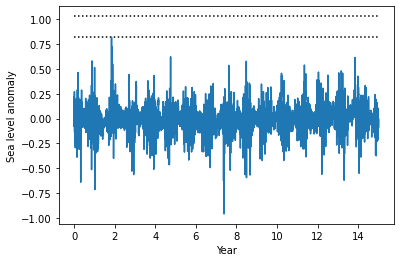

In [30]:
## Plotting the return levels
fig, ax = plt.subplots(figsize=(6,4))
xs = np.linspace(0, 15, len(new_york_detrended_timeseries))
ax.plot(xs, new_york_detrended_timeseries)
ax.set_xlabel('Year')
ax.set_ylabel('Sea level anomaly')
ax.hlines((z_1, z_10), 0, 15, ls=':')

print('1-year return height: ', z_1)
print('10-year return height: ', z_10)

## Doing this for general cities

In [31]:
def get_return_levels(city, percentile=99, make_plot=False):
    z=z_dict[city]
    sla_timeseries = seasonal_anomaly.isel(z=z).data
    extremes = extreme_values(sla_timeseries, percentile=percentile)

    z_1 = return_levels(sla_timeseries, percentile=percentile)
    z_10 = return_levels(sla_timeseries, percentile=percentile, T=3650)
    
    if make_plot:
        k, θ, σ = genpareto.fit(extremes)
        x = np.linspace(genpareto.ppf(0.01, k, θ, σ), genpareto.ppf(0.99, k, θ, σ), 100)
        
        fig, ax = plt.subplots(ncols=2, figsize=(20,6))
        ax[0].hist(extremes, density=True, label='Data')
        ax[0].plot(x, genpareto.pdf(x, k, θ, σ), label='Pareto fit')
        ax[0].legend()
        ax[0].set_xlabel('Sea level anomaly')
        ax[0].set_ylabel('Probability density')
        ax[0].set_title('Best fit Pareto distribution to SL extremes, '+city+' (threshold='+str(percentile)+ '%)')

        xs = np.linspace(0, 15, len(sla_timeseries))
        ax[1].plot(xs, sla_timeseries)
        ax[1].set_xlabel('Year')
        ax[1].set_ylabel('Sea level anomaly')
        ax[1].set_ylim(-.6,1.1)
        ax[1].set_title('Sea level timeseries, ' + city + r' ($z_1 = $' + str(round(z_1,3)) + ' meters)')
        ax[1].hlines(z_1, 0, 15, ls=':', label='1-year return level')
        #ax[1].hlines(z_10, 0, 15, ls='--', label='10-year return level')
        ax[1].legend(loc='lower right')
    
    return z_1, z_10
get_return_levels('New York') 

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.9251670382541788, 1.1271929717447278)

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered 

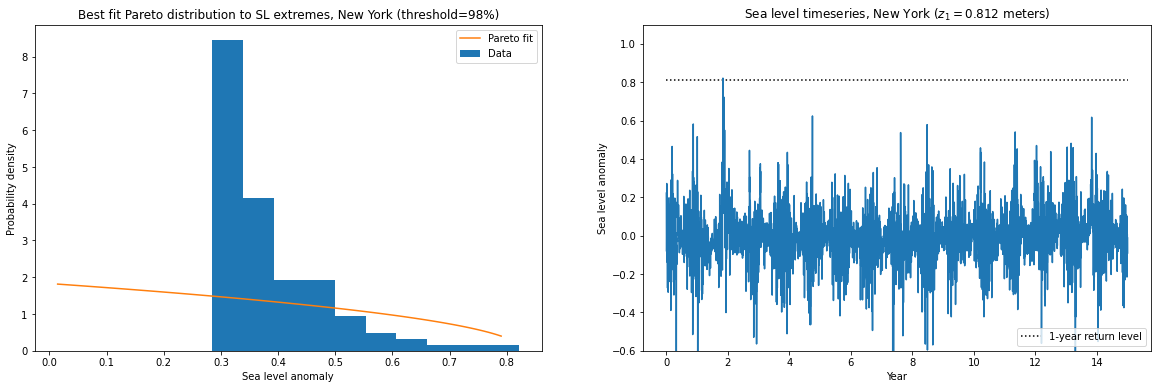

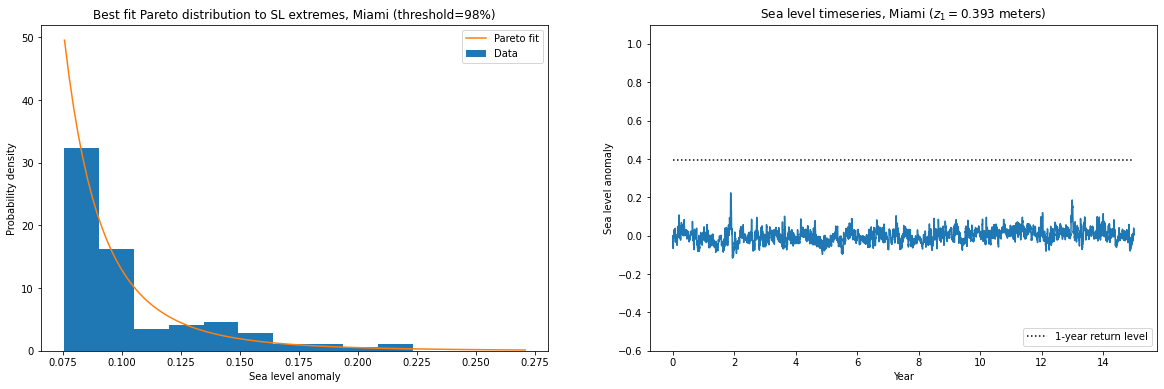

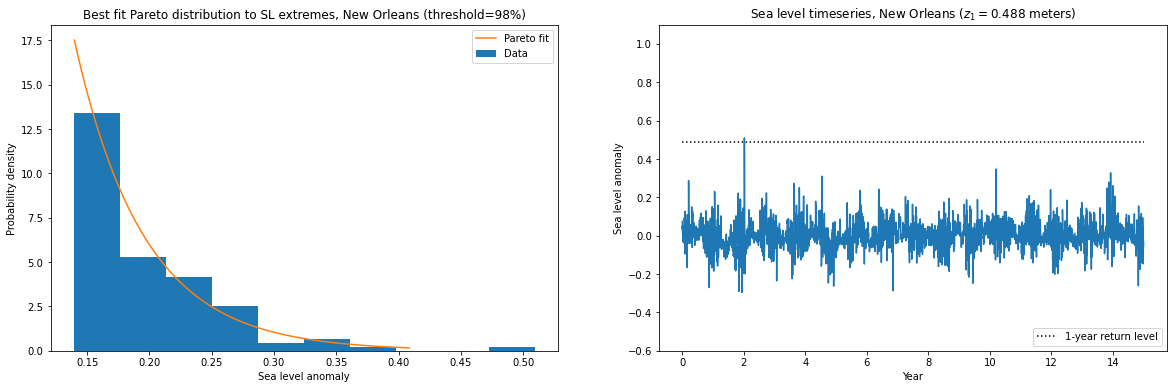

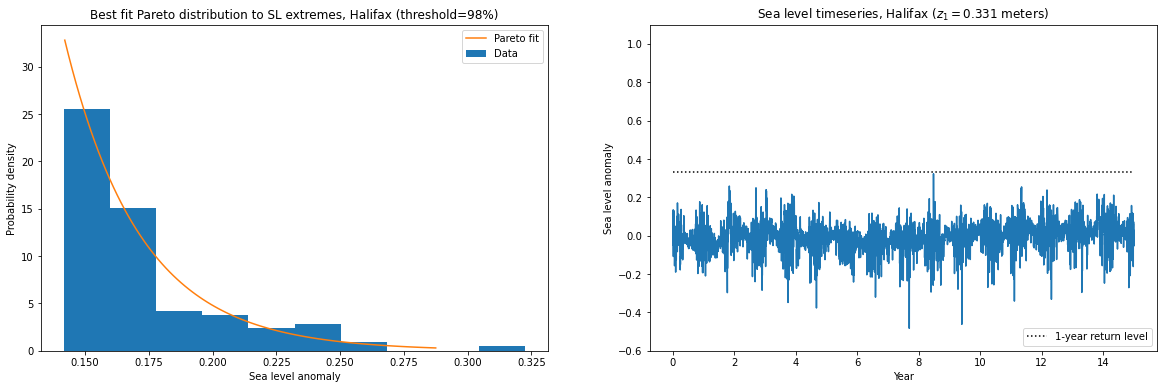

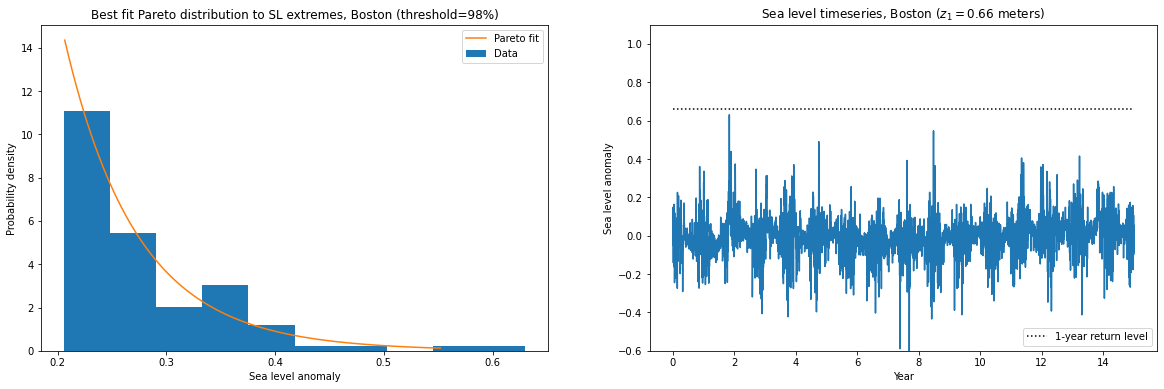

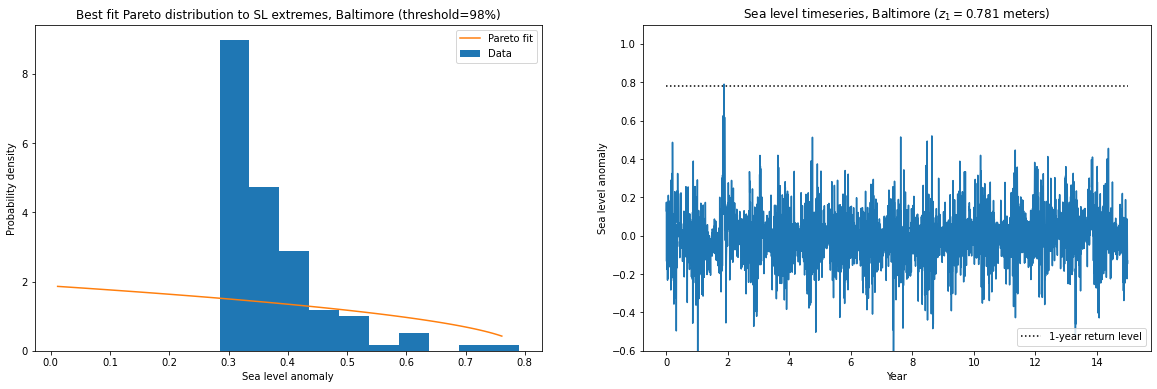

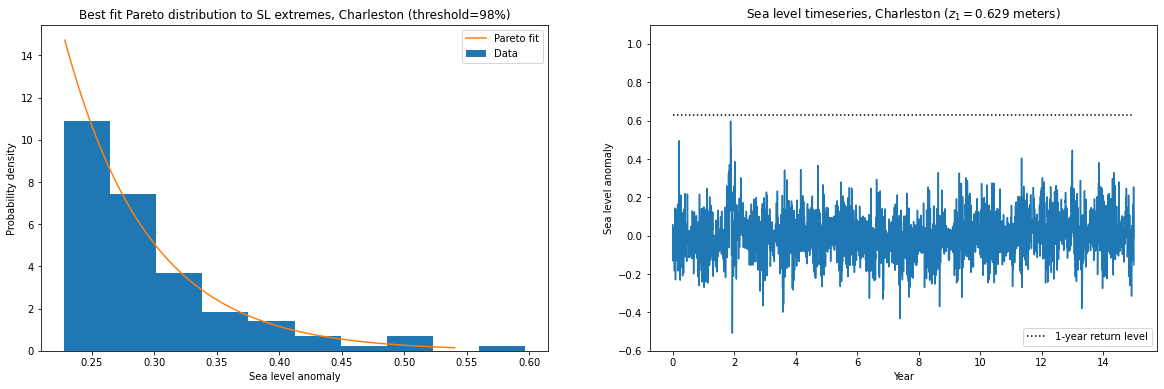

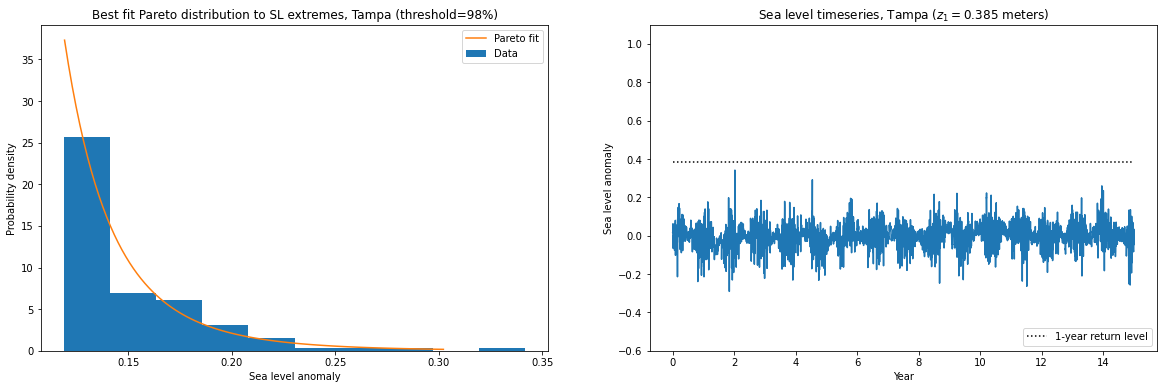

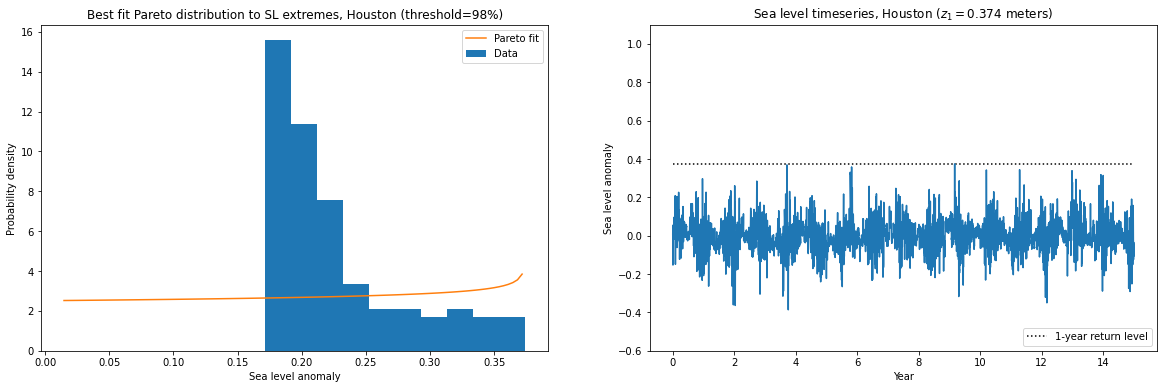

In [32]:
z1s = {}
z10s = {}

for city in cities:
    z1, z10 = get_return_levels(city, percentile=98, make_plot=True)
    z1s[city] = z1
    z10s[city] = z10

In [33]:
shelf_length_dict = {}
for city in cities:
    shelf_length_dict[city] = df['shelf_length'].loc[z_dict[city]]
shelf_length_dict = {k: v for k, v in sorted(shelf_length_dict.items(), key=lambda item: item[1])}
shelf_length_dict

reordered_cities = list(shelf_length_dict.keys())
reordered_cities

['Miami',
 'Halifax',
 'Boston',
 'Charleston',
 'New York',
 'New Orleans',
 'Baltimore',
 'Tampa',
 'Houston']

Text(0.5, 1.0, 'Computed shelf widths at various US coastal cities')

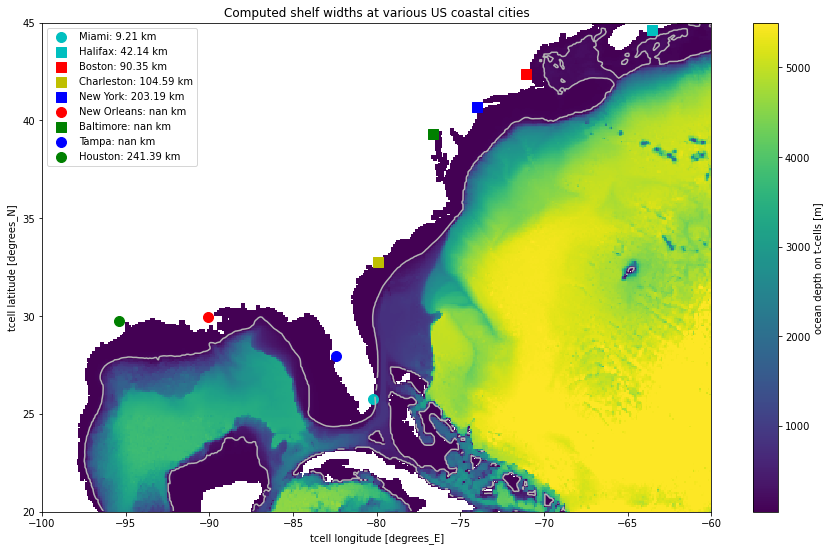

In [34]:
# bathymetry = bathymetry['ht'].where(bathymetry['ht'] <= 140, np.nan).where(bathymetry['ht'] >0, np.nan)
bathymetry = bathymetry['ht'].where(bathymetry['ht'] >0, np.nan)
fig, ax = plt.subplots(figsize=(15,9))
bathymetry.sel(xt_ocean=slice(-100, -60), yt_ocean=slice(20,45)).plot(ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot 140m isobar
bathymetry.sel(xt_ocean=slice(-100, -60), yt_ocean=slice(20,45)).plot.contour(ax=ax, levels=[140], colors=[(.7,.7,.7)])

for city in reordered_cities:
    shelf_length = round(shelf_length_dict[city] / 1000, 2)
    lat = geocoords[city][0]
    lon = geocoords[city][1]
    ax.scatter(lon, lat, marker=marker_dict[city], s=100, color=c_dict[city], 
               label=city + ': ' + str(shelf_length) + ' km')
    
ax.legend(loc='upper left')
ax.set_title('Computed shelf widths at various US coastal cities')

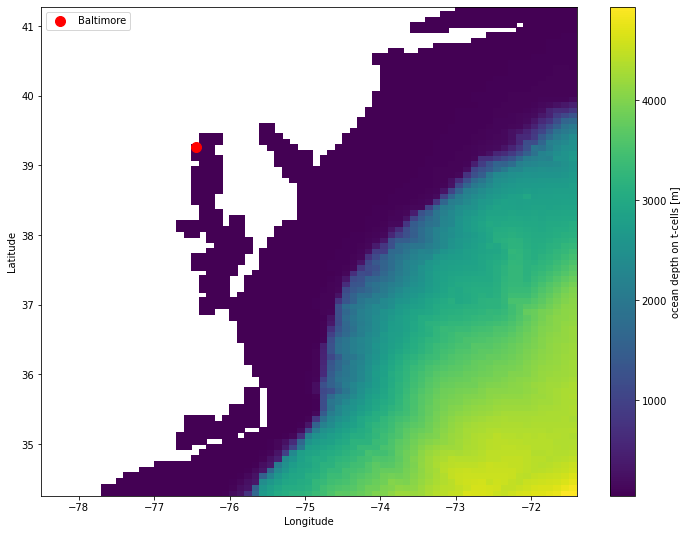

In [35]:
bathymetry = bathymetry['ht'].where(bathymetry['ht'] > 0, np.nan)
fig, ax = plt.subplots(figsize=(12,9))
lat = df.loc[z_dict['Baltimore']]['yt_ocean']
lon = df.loc[z_dict['Baltimore']]['xt_ocean']
bathymetry.sel(yt_ocean=slice(lat - 5, lat + 2), xt_ocean=slice(lon - 2, lon + 5)).plot(ax=ax)
ax.scatter(lon, lat, marker='o', s=100, color='r', 
               label='Baltimore')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='upper left')

In [36]:
geocoords['Baltimore']
near = df[abs(df['yt_ocean'] - 37) <= .5]
near = near[abs(near['xt_ocean'] + 76) <= 0.1]
near

,yt_ocean,xt_ocean,std,skew,kurtosis,shelf_length
z,,,,,,
103160,36.978306,-76.05,0.117537,0.357508,6.404173,151799.903323
103161,37.058150,-76.05,0.118232,0.373160,6.467856,142618.810646
103162,37.137911,-76.05,0.118353,0.364135,6.355131,NaN
103163,37.217587,-76.05,0.119226,0.366034,6.418578,NaN
103164,37.297180,-76.05,0.118561,0.356628,6.313382,NaN
103165,37.376688,-76.05,0.119298,0.352146,6.374947,NaN
103166,37.456112,-76.05,0.118882,0.330086,6.255849,NaN
103291,36.818366,-75.95,0.119299,0.416716,6.660362,142043.030348
103292,36.898378,-75.95,0.116103,0.400841,6.645913,143139.701135


In [40]:
z_chesapeake = 103160

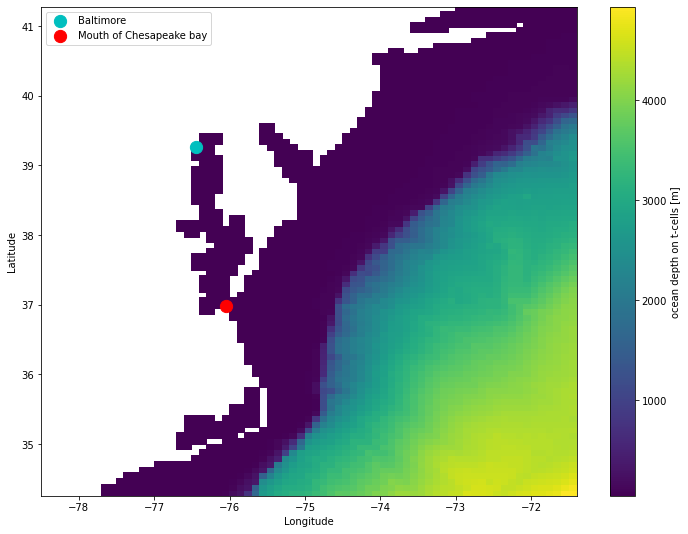

In [41]:
bathymetry = bathymetry['ht'].where(bathymetry['ht'] > 0, np.nan)

fig, ax = plt.subplots(figsize=(12,9))
lat = df.loc[z_dict['Baltimore']]['yt_ocean']
lon = df.loc[z_dict['Baltimore']]['xt_ocean']
out_lat = df.loc[z_chesapeake]['yt_ocean']
out_lon = df.loc[z_chesapeake]['xt_ocean']

bathymetry.sel(yt_ocean=slice(lat - 5, lat + 2), xt_ocean=slice(lon - 2, lon + 5)).plot(ax=ax)
ax.scatter(lon, lat, marker='o', s=150, color='c', 
               label='Baltimore')
ax.scatter(out_lon, out_lat, marker='o', s=150, color='r', 
               label='Mouth of Chesapeake bay')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='upper left')

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered 

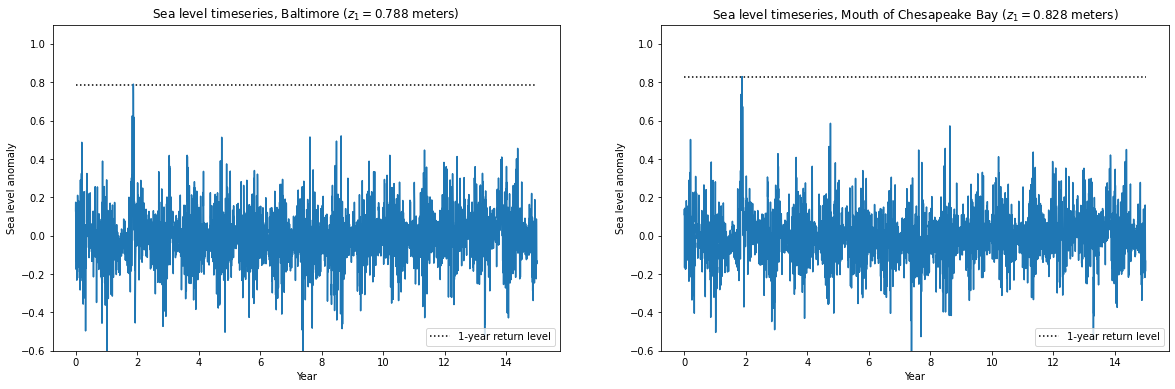

In [42]:
# Compare timeseries and return levels at interior of chesapeake bay and mouth of the Chesapeake

fig, ax = plt.subplots(ncols=2, figsize=(20,6))

baltimore_sla_timeseries = seasonal_anomaly.isel(z=z_dict['Baltimore']).data
extremes = extreme_values(baltimore_sla_timeseries, percentile=99)
z_1 = return_levels(baltimore_sla_timeseries, percentile=99)
k, θ, σ = genpareto.fit(extremes)
x = np.linspace(genpareto.ppf(0.01, k, θ, σ), genpareto.ppf(0.99, k, θ, σ), 100)
xs = np.linspace(0, 15, len(baltimore_sla_timeseries))

ax[0].plot(xs, baltimore_sla_timeseries)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Sea level anomaly')
ax[0].set_ylim(-.6,1.1)
ax[0].set_title('Sea level timeseries, Baltimore' + r' ($z_1 = $' + str(round(z_1,3)) + ' meters)')
ax[0].hlines(z_1, 0, 15, ls=':', label='1-year return level')
ax[0].legend(loc='lower right')

chesapeake_sla_timeseries = seasonal_anomaly.isel(z=z_chesapeake).data
extremes = extreme_values(chesapeake_sla_timeseries, percentile=99)
z_1 = return_levels(chesapeake_sla_timeseries, percentile=99)
k, θ, σ = genpareto.fit(extremes)
x = np.linspace(genpareto.ppf(0.01, k, θ, σ), genpareto.ppf(0.99, k, θ, σ), 100)
xs = np.linspace(0, 15, len(chesapeake_sla_timeseries))


ax[1].plot(xs, chesapeake_sla_timeseries)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Sea level anomaly')
ax[1].set_ylim(-.6,1.1)
ax[1].set_title('Sea level timeseries, Mouth of Chesapeake Bay' + r' ($z_1 = $' + str(round(z_1,3)) + ' meters)')
ax[1].hlines(z_1, 0, 15, ls=':', label='1-year return level')
ax[1].legend(loc='lower right')

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2282: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered 

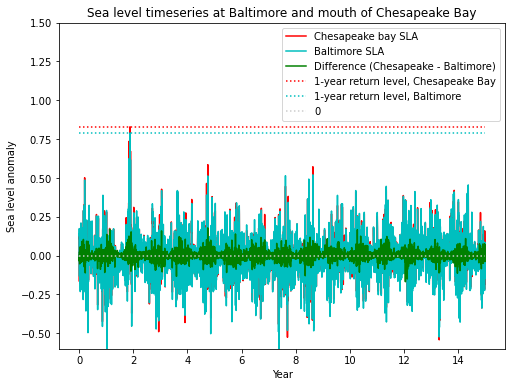

In [67]:
fig, ax = plt.subplots(figsize=(8,6))

z_1_chesapeake = return_levels(chesapeake_sla_timeseries, percentile=99)
ax.plot(xs, chesapeake_sla_timeseries, label='Chesapeake bay SLA', color='r', zorder=0)
ax.set_xlabel('Year')
ax.set_ylabel('Sea level anomaly')
ax.set_ylim(-.6,1.5)
ax.set_title('Sea level timeseries, Mouth of Chesapeake Bay' + r' ($z_1 = $' + str(round(z_1,3)) + ' meters)')
ax.hlines(z_1_chesapeake, 0, 15, ls=':', colors='r', label='1-year return level, Chesapeake Bay')

z_1_baltimore = return_levels(baltimore_sla_timeseries, percentile=99)
ax.plot(xs, baltimore_sla_timeseries, label='Baltimore SLA', color='c', zorder=1)


ax.set_xlabel('Year')
ax.set_ylabel('Sea level anomaly')
ax.set_ylim(-.6,1.5)
ax.set_title('Sea level timeseries at Baltimore and mouth of Chesapeake Bay')
ax.hlines(z_1_baltimore, 0, 15, ls=':', colors='c', label='1-year return level, Baltimore')

diff = chesapeake_sla_timeseries - baltimore_sla_timeseries

ax.plot(xs, diff, c='g', label='Difference (Chesapeake - Baltimore)', zorder=2)

ax.hlines(0., 0, 15, ls=':', colors=(0.8,0.8,0.8), label='0', zorder=3)

ax.legend(loc='upper right')
